In [1]:
# import os
# os.environ["TRITON_INTERPRET"] = "1"

In [1]:
import torch
from model_triton import t_scaled_dot_prod_attn_fwd3

#BS, H, N, D = 1, 1, 512, 64
BS, H, N, D = 8, 12, 512, 64
#BS, H, N, D = 1, 1, 512, 64
#BS, H, N, D = 2, 2, 128, 64 # -> out of resources for tiling along Q_N, but not along Q_N and K_T_N
#BS, H, N, D = 2, 2, 128, 32
#BS, H, N, D = 2, 2, 64, 32
#BS, H, N, D = 2, 2, 32, 16
#BS, H, N, D = 2, 2, 32, 32
#BS, H, N, D = 2, 2, 16, 16
qkv = torch.randn((BS, H, 3, N, D), device="cuda")
mask = torch.tril(torch.ones((N,N), dtype=torch.bool, device="cuda")).unsqueeze(0).expand(BS, N, N)
#mask = torch.ones((N,N), dtype=torch.bool, device="cuda").unsqueeze(0).expand(BS, N, N)
#train=True
train=False #True
p_gen_aux = 42
N_RUNS = 1 #10

def fn_naive(qkv):
    return t_scaled_dot_prod_attn_fwd3(qkv, mask, train, p_gen_aux)
fn_jit = torch.compile(fn_naive)
# burn it
fn_jit(qkv) 
#fn_jit(dloss_dx, qkv) 

# from torch.profiler import profile, record_function, ProfilerActivity, schedule
# activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
# with profile(activities=activities, record_shapes=True) as prof:
#     for _ in range(N_RUNS):
#         result = fn_jit(qkv)
#         #result = fn_jit(dloss_dx, qkv)
        
# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

import time
t0 = time.time()
for _ in range(N_RUNS):
    result, _ = fn_jit(qkv)
    #result = fn_jit(dloss_dx, qkv)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'JIT total', total)

import time
t0 = time.time()
for _ in range(N_RUNS):
    result, _ = fn_naive(qkv)
    #result = fn_naive(dloss_dx, qkv)
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'Naive total', total)
#print('result', result.shape, result[:2,:2,:4, :4])
print('result', result.shape, result[:2,:2,-4:, -4:])

JIT total 0.0012600421905517578
Naive total 0.1251528263092041
result torch.Size([8, 12, 512, 64]) tensor([[[[-0.0147, -0.0191, -0.0007,  0.0881],
          [-0.0190, -0.0752,  0.0516, -0.0015],
          [ 0.0567, -0.0462,  0.0748, -0.0474],
          [-0.0485,  0.0029,  0.0599,  0.0465]],

         [[ 0.0014,  0.0510, -0.1349, -0.0363],
          [ 0.0727, -0.0193, -0.0404,  0.0435],
          [ 0.0519,  0.0156, -0.0259,  0.0124],
          [-0.0086,  0.0813,  0.0856, -0.0421]]],


        [[[ 0.0432, -0.0077, -0.0009,  0.0945],
          [ 0.0584, -0.1202, -0.0198,  0.1099],
          [ 0.0484, -0.0059,  0.0071,  0.0618],
          [ 0.1038,  0.0056,  0.0180,  0.0257]],

         [[ 0.0892,  0.0461, -0.0417, -0.0560],
          [ 0.0083, -0.0163,  0.0072,  0.0179],
          [-0.0356,  0.0231, -0.1378, -0.0606],
          [ 0.0943, -0.0408,  0.0380, -0.0891]]]], device='cuda:0')


In [3]:
import triton
import triton.language as tl

from model_triton import gelu_k, T_DROPOUT_RATE, dropout_k

# This will work for moderate size of D: it's tiling along N dimension of Q, and along N dimension of K_T&V.
# It doesn't tile along D dimension.
# Different program per BS_H item (reshape of BS and H in one dim, and one program per this dim)
@triton.jit
def t_scaled_dot_prod_attn_fwd3_k(q_ptr, k_t_ptr, v_ptr, mask_ptr, output_ptr, acts0_ptr, acts1_ptr,
                q_stride0, q_stride1, q_stride2, k_t_stride0, k_t_stride1, k_t_stride2,
                v_stride0, v_stride1, v_stride2, mask_stride0, mask_stride1,
                output_stride0, output_stride1, output_stride2, acts0_stride0, acts1_stride0,
                train, p_gen_aux,
                BS_H, N:tl.constexpr, D,
                BLOCK_SIZE_Q_N: tl.constexpr, BLOCK_SIZE_K_T_N: tl.constexpr, BLOCK_SIZE_D: tl.constexpr,
                Q_N_BLCKS: tl.constexpr,
                num_stages: tl.constexpr
                ):
    # Matching PyTorch's fp32 dtype ( see https://github.com/triton-lang/triton/issues/4574)
    ASM: tl.constexpr = "cvt.rna.tf32.f32 $0, $1;"
    
    sqrt_D = tl.sqrt(D.to(tl.float32)) # TODO T: extract from this method?
    bs_h_start = tl.program_id(0)
    bs_h_step = tl.num_programs(0)
    for bs_h_pid in tl.range(bs_h_start, BS_H, bs_h_step, num_stages):
        bs_h_q_ptr = q_ptr + bs_h_pid * q_stride0
        bs_h_k_t_ptr = k_t_ptr + bs_h_pid * k_t_stride0    
        bs_h_v_ptr = v_ptr + bs_h_pid * v_stride0        
        bs_h_output_ptr = output_ptr + bs_h_pid * output_stride0
        bs_h_acts0_ptr = acts0_ptr + bs_h_pid * acts0_stride0
        bs_h_acts1_ptr = acts1_ptr + bs_h_pid * acts1_stride0     
        
        for q_n_step in tl.static_range(0, Q_N_BLCKS):          
            q_n_offsets = q_n_step * BLOCK_SIZE_Q_N + tl.arange(0, BLOCK_SIZE_Q_N)            
            d_offsets = tl.arange(0, BLOCK_SIZE_D)
            # TODO T: Do I need modulo n, modulo m operations? 
            q_n_offsets_mod = q_n_offsets % N
            d_offsets_mod = d_offsets %D
            
            # Load Q blck once
            q_blck_ptr = bs_h_q_ptr + q_n_offsets_mod[:,None] * q_stride1 + d_offsets_mod[None, :] * q_stride2
            q_blck_mask = (q_n_offsets[:,None] < N) & (d_offsets[None, :] < D)
            q_blck = tl.load(q_blck_ptr, mask=q_blck_mask, other=0.0) 
            
            # Use FlashAttention naming: ms - logits' max, ls - logit's sumexp
            ms = tl.full((BLOCK_SIZE_Q_N, 1), -1e9, tl.float32)
            ls = tl.zeros_like(ms)
            output = tl.zeros((BLOCK_SIZE_Q_N, BLOCK_SIZE_D), dtype=tl.float32)

            # ASSUMES CAUSAL MASK FOR NOW 
            # This is somehow limited suppport for now. I only tested this for BLOCK_SIZE_Q_N = 2x BLOCK_SIZE_K_T_N
            k_t_n_step_end = min(tl.cdiv(N, BLOCK_SIZE_K_T_N), (q_n_step+1) *tl.cdiv(BLOCK_SIZE_Q_N, BLOCK_SIZE_K_T_N))
            
            for k_t_n_step in range(0, k_t_n_step_end):
                k_t_n_offsets = k_t_n_step * BLOCK_SIZE_K_T_N + tl.arange(0, BLOCK_SIZE_K_T_N) 
                k_t_n_offsets_mod = k_t_n_offsets % N
                
                # Q * K^T
                k_blck_ptr = bs_h_k_t_ptr + d_offsets_mod[:,None] * k_t_stride1 + k_t_n_offsets_mod[None, :] * k_t_stride2
                k_blck_mask = (d_offsets[:, None] < D) & (k_t_n_offsets[None, :] < N)
                k_blck = tl.load(k_blck_ptr, mask=k_blck_mask, other=0.0)
                # Matching PyTorch's fp32 dtype ( see https://github.com/triton-lang/triton/issues/4574)
                q_blck = tl.inline_asm_elementwise(ASM, "=r, r", [q_blck], dtype=tl.float32, is_pure=True, pack=1)
                k_blck = tl.inline_asm_elementwise(ASM, "=r, r", [k_blck], dtype=tl.float32, is_pure=True, pack=1)
                acc = tl.dot(q_blck, k_blck)

                # /sqrt(D) + Mask + Softmax + Dropout (with keeping updating ms&ls following FlashAttention's paper)
                acc = acc / sqrt_D
                mask_blck_ptr = mask_ptr + q_n_offsets_mod[:,None] * mask_stride0 + k_t_n_offsets_mod[None, :] * mask_stride1
                mask_mask = (q_n_offsets[:,None] <N) & (k_t_n_offsets[None, :]<N)
                mask_blck = tl.load(mask_blck_ptr, mask=mask_mask, other= 0.0)
                acc = tl.where(mask_blck, acc, -1e9)
                blck_ms = tl.max(acc, axis=1, keep_dims=True)
                n_ms = tl.maximum(ms, blck_ms)
                acc = tl.exp(acc - blck_ms)
                blck_ls = tl.sum(acc, axis=1, keep_dims=True)       
                n_ls = tl.exp(ms - n_ms) * ls + tl.exp(blck_ms - n_ms) * blck_ls
                # TODO T: confirm that this is different enough seed per row (assumes that D_PID always equals to 0)
                acc = dropout_k(acc, train, p_gen_aux+bs_h_pid, q_n_offsets[:,None] + k_t_n_offsets[None, :])

                # * V
                v_blck_ptr = bs_h_v_ptr + k_t_n_offsets_mod[:,None] * v_stride1 + d_offsets_mod[None, :] * v_stride2
                v_blck_mask = (k_t_n_offsets[:, None] < N) & (d_offsets[None, :]<D)
                v_blck = tl.load(v_blck_ptr, mask=v_blck_mask, other=0.0)
                v_blck = tl.inline_asm_elementwise(ASM, "=r, r", [v_blck], dtype=tl.float32, is_pure=True, pack=1)
                
                output = 1/n_ls * (ls * tl.exp(ms - n_ms) * output + tl.exp(blck_ms - n_ms) * tl.dot(acc, v_blck))
                ms, ls = n_ms, n_ls
                
            tl.store(bs_h_acts0_ptr + q_n_offsets, ms.reshape(BLOCK_SIZE_Q_N), mask=q_n_offsets<N)
            tl.store(bs_h_acts1_ptr + q_n_offsets, ls.reshape(BLOCK_SIZE_Q_N), mask=q_n_offsets<N)  
            output_blck_ptr = bs_h_output_ptr + q_n_offsets[:,None] * output_stride1 + d_offsets[None, :] * output_stride2
            output_mask = (q_n_offsets[:,None] <N) & (d_offsets[None, :]<D)
            tl.store(output_blck_ptr, output, mask=output_mask)
    

def n_t_scaled_dot_prod_attn_fwd3_t(qkv:torch.Tensor, mask:torch.Tensor, train=True, p_gen_aux=None):
    q, k, v = torch.unbind(qkv, dim=2) # BS x H x N x D
    BS, H, N, D = q.shape
    
    q = q.reshape(BS*H, N, D)
    k = k.reshape(BS*H, N, D)
    v = v.reshape(BS*H, N, D)
    mask = mask[0] # Asumme mask being the same across rows. TODO XXX: make that assumption throughput the code
    
    output = torch.zeros_like(q)
    acts0 = torch.empty((BS*H, N), device=q.device)
    acts1 = torch.empty_like(acts0)
    
    # TODO T: check if some matrices are contiguous?
    grid = (min(BS*H, 80),)

    # Tuned params given num_warps=8, and BS, H, N, D = 8, 12, 512, 64
    num_warps = 8
    num_stages = 2 # TODO T: I don't think this helps
    BLOCK_SIZE_Q_N = 128
    BLOCK_SIZE_K_T_N = 64
    BLOCK_SIZE_D = triton.next_power_of_2(D)
    
    # We enforce causal masking for now, but the assert below cost too much perf
    #assert torch.allclose(mask, torch.tril(torch.ones((N, N), device=mask.device, dtype=torch.bool))), "Assumes causal mask"
    assert BLOCK_SIZE_Q_N >= BLOCK_SIZE_K_T_N, "Due to the limited support for levarging causal mask"

    if not train:
        p_gen_aux = 0 # Need to mock some value for triton to compile the kernel without errors
    k_t = torch.transpose(k, -2, -1)
    t_scaled_dot_prod_attn_fwd3_k[grid](
        q, k_t, v, mask, output, acts0, acts1,
        q.stride(0), q.stride(1), q.stride(2), k_t.stride(0), k_t.stride(1), k_t.stride(2), 
        v.stride(0), v.stride(1), v.stride(2),
        mask.stride(0), mask.stride(1), output.stride(0), output.stride(1), output.stride(2),
        acts0.stride(0), acts1.stride(0),
        train, p_gen_aux,
        BS*H, N, D,
        BLOCK_SIZE_Q_N=BLOCK_SIZE_Q_N, BLOCK_SIZE_K_T_N = BLOCK_SIZE_K_T_N, BLOCK_SIZE_D=BLOCK_SIZE_D,
        Q_N_BLCKS = triton.cdiv(N, BLOCK_SIZE_Q_N), # TODO T: Is there a way to do that cdiv inside kernel?
        num_warps=num_warps, num_stages=num_stages)
    
    output = output.reshape(BS, H, N, D)
    return output, [acts0.reshape(BS, H, N), acts1.reshape(BS, H, N), output]

def fn_t(qkv):
    return n_t_scaled_dot_prod_attn_fwd3_t(qkv, mask, train, p_gen_aux)

# from torch.profiler import profile, record_function, ProfilerActivity, schedule
# activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]
# with profile(activities=activities, record_shapes=True) as prof:
#     for _ in range(N):
#         #result = fn_t(aa)
#         #result = fn_t(dloss_dx, aa)
#         result = fn_t(aa, bb)
# print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=20))

# fn_t(qkv)

import time
t0 = time.time()
for _ in range(N_RUNS):
    result2, new_acts = fn_t(qkv)
    #result = fn_t(dloss_dx, qkv)
    
#print(f'result2[1][0]', result2[1][0].shape, result2[1][0])
#print(f'result2[1][1]', result2[1][1].shape, result2[1][1])
#result2 = result2[0]
    
torch.cuda.synchronize()
t1 = time.time()
total = t1-t0
print(f'total', total)
#print('result2', result2.shape, result2[:2, :2, :4, :4])
print('result2', result2.shape, result2[:2, :2, -4:, -4:])

assert torch.allclose(result, result2, rtol=5e-2, atol=1e-3), (result.shape, result2.shape, result[:2, :2, -4:, -4:], result2[:2, :2, -4:, -4:])

#assert torch.allclose(result, result2, rtol=1e-1, atol=1e-3), (result.shape, result2.shape, result[:2, :2, :4, :4], result2[:2, :2, :4, :4])
#assert torch.allclose(result, result2, rtol=5e-2, atol=4e-4), (result.shape, result2.shape, result[:2, :2, -4:, -4:], result2[:2, :2, -4:, -4:])
#assert torch.allclose(result, result2, rtol=3e-2, atol=4e-4), (result.shape, result2.shape, result[:2, :2, -4:, -4:], result2[:2, :2, -4:, -4:])
#assert torch.allclose(result, result2, rtol=1e-2, atol=5e-4), (result.shape, result2.shape, result[:2, :2, -4:, -4:], result2[:2, :2, -4:, -4:])

loc(callsite("/efs/notebooks/mkukla/pre-tjax/model_triton.py":1466:7 at "/tmp/ipykernel_3931/3640614592.py":80:64)): error: operation scheduled before its operands
loc(callsite("/efs/notebooks/mkukla/pre-tjax/model_triton.py":1466:7 at "/tmp/ipykernel_3931/3640614592.py":80:64)): error: operation scheduled before its operands
loc(callsite("/efs/notebooks/mkukla/pre-tjax/model_triton.py":1466:7 at "/tmp/ipykernel_3931/3640614592.py":80:64)): error: operation scheduled before its operands
loc(callsite("/efs/notebooks/mkukla/pre-tjax/model_triton.py":1466:7 at "/tmp/ipykernel_3931/3640614592.py":80:64)): error: operation scheduled before its operands


total 7.716773986816406
result2 torch.Size([8, 12, 512, 64]) tensor([[[[-0.0147, -0.0191, -0.0007,  0.0880],
          [-0.0190, -0.0752,  0.0516, -0.0015],
          [ 0.0567, -0.0462,  0.0748, -0.0474],
          [-0.0485,  0.0029,  0.0599,  0.0465]],

         [[ 0.0014,  0.0510, -0.1348, -0.0363],
          [ 0.0727, -0.0193, -0.0404,  0.0435],
          [ 0.0519,  0.0156, -0.0258,  0.0124],
          [-0.0086,  0.0813,  0.0856, -0.0421]]],


        [[[ 0.0432, -0.0078, -0.0009,  0.0945],
          [ 0.0584, -0.1202, -0.0198,  0.1099],
          [ 0.0484, -0.0059,  0.0071,  0.0618],
          [ 0.1038,  0.0057,  0.0180,  0.0257]],

         [[ 0.0892,  0.0461, -0.0417, -0.0560],
          [ 0.0083, -0.0163,  0.0072,  0.0179],
          [-0.0355,  0.0230, -0.1378, -0.0606],
          [ 0.0943, -0.0408,  0.0380, -0.0891]]]], device='cuda:0')


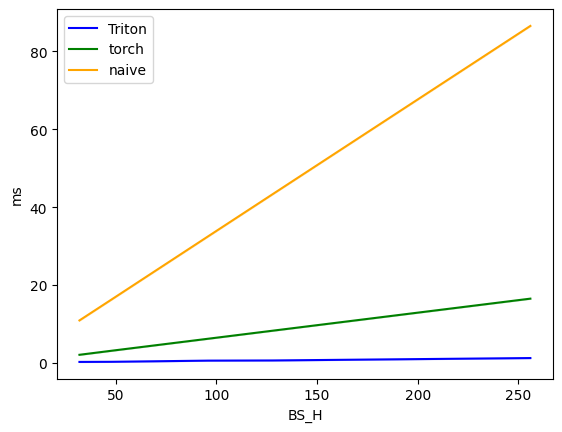

t_scaled_dot_prod_attn_fwd_t:
    BS_H    Triton      torch      naive
0   32.0  0.262176   2.092800  10.914832
1   48.0  0.291856   3.135424  16.304832
2   96.0  0.593376   6.219424  32.534401
3  128.0  0.636336   8.280032  43.340958
4  256.0  1.254720  16.508512  86.533279


In [4]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['BS_H'],  # Argument names to use as an x-axis for the plot.
        x_vals=[32, 48, 96, 128, 256],
        #x_vals=[128 * 2**i for i in range(0, 6)],
        #x_vals=[128 * i for i in range(2, 33)],  # Different possible values for `x_name`.
        #x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch', 'naive'],  # Possible values for `line_arg`.
        line_names=['Triton', 'torch', 'naive'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # Line styles.
        ylabel='ms',  # Label name for the y-axis.
        plot_name='t_scaled_dot_prod_attn_fwd_t',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
        # TODO T: Use real M i.e. 
    ))
def benchmark(BS_H, provider):
    #BS, H, N, D = 1, BS_H, 32, 16
    #BS, H, N, D = 8, 12, 512, 64
    BS, H, N, D = 1, BS_H, 512, 64
    qkv = torch.randn((BS, H, 3, N, D), device="cuda")  
    quantiles = [0.5, 0.2, 0.8]
    if provider == 'torch':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(qkv), quantiles=quantiles)
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(dloss_dx, x), quantiles=quantiles)
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_jit(aa, bb), quantiles=quantiles)
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(aa, bb), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(qkv), quantiles=quantiles)        
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(dloss_dx, x), quantiles=quantiles)
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_t(aa, bb), quantiles=quantiles)
    if provider == 'naive':
       ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(qkv), quantiles=quantiles)
       #ms, min_ms, max_ms = triton.testing.do_bench(lambda: fn_naive(dloss_dx, x), quantiles=quantiles)
    #perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3) # TODO XXX: investigate whether this is right. In the tutorial they operate on different dtype
    perf = lambda ms: ms
    return perf(ms), perf(max_ms), perf(min_ms)
benchmark.run(print_data=True, show_plots=True)

In [14]:
import torch
print(torch.cuda.get_device_properties("cuda"))
from triton.runtime import driver
device = torch.cuda.current_device()
properties = driver.active.utils.get_device_properties(device)
NUM_SM = properties["multiprocessor_count"]
SIZE_SMEM = properties["max_shared_mem"]
NUM_REGS = properties["max_num_regs"]
WARP_SIZE = properties["warpSize"] # Not 64 as A100
properties

_CudaDeviceProperties(name='NVIDIA A10G', major=8, minor=6, total_memory=22723MB, multi_processor_count=80, uuid=61ea3d2d-53a8-44f6-4844-0bcc29aa720b, L2_cache_size=6MB)


{'max_shared_mem': 101376,
 'max_num_regs': 65536,
 'multiprocessor_count': 80,
 'warpSize': 32,
 'sm_clock_rate': 1710000,
 'mem_clock_rate': 6251000,
 'mem_bus_width': 384}

In [15]:
num_stages = 4 if SIZE_SMEM > 200000 else 2
num_warps = 8
print(f'num_stages', num_stages, 'num_warps', num_warps)

q, k, v = torch.unbind(qkv, dim=2) # BS x H x N x D
BS, H, N, D = q.shape
q = q.reshape(BS*H, N, D)
k = k.reshape(BS*H, N, D)
v = v.reshape(BS*H, N, D)
temp_mask = mask[0] # Asumme mask being the same across rows. TODO XXX: make that assumption throughput the code
output = torch.zeros_like(q)
acts0 = torch.empty((BS*H, N), device=q.device)
acts1 = torch.empty_like(acts0)
BLOCK_SIZE_Q_N = 128
BLOCK_SIZE_K_T_N = 64
BLOCK_SIZE_D = triton.next_power_of_2(D) #16

k_t = torch.transpose(k, -2, -1)
kernel = t_scaled_dot_prod_attn_fwd3_k.warmup(
    q, k_t, v, temp_mask, output, acts0, acts1,
    q.stride(0), q.stride(1), q.stride(2), k_t.stride(0), k_t.stride(1), k_t.stride(2), 
    v.stride(0), v.stride(1), v.stride(2),
    temp_mask.stride(0), temp_mask.stride(1), output.stride(0), output.stride(1), output.stride(2),
    acts0.stride(0), acts1.stride(1),
    train, p_gen_aux,
    BS*H, N, D,
    BLOCK_SIZE_Q_N = BLOCK_SIZE_Q_N, BLOCK_SIZE_K_T_N = BLOCK_SIZE_K_T_N, BLOCK_SIZE_D=BLOCK_SIZE_D, 
    Q_N_BLCKS = triton.cdiv(N, BLOCK_SIZE_Q_N),
    grid=(1, ), num_warps=num_warps, num_stages=num_stages)

kernel._init_handles()
n_regs = kernel.n_regs
size_smem = kernel.metadata.shared
print(f'n_regs', n_regs, 'size_smem', size_smem)

occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
print(f'occupancy', occupancy, SIZE_SMEM // size_smem)
occupancy = min(occupancy, SIZE_SMEM // size_smem)
num_programs = NUM_SM * occupancy
print(f'num_programs', num_programs)

num_stages 2 num_warps 8


loc(callsite("/efs/notebooks/mkukla/pre-tjax/model_triton.py":1488:7 at "/tmp/ipykernel_9552/3979756168.py":133:64)): error: operation scheduled before its operands
loc(callsite("/efs/notebooks/mkukla/pre-tjax/model_triton.py":1488:7 at "/tmp/ipykernel_9552/3979756168.py":133:64)): error: operation scheduled before its operands
loc(callsite("/efs/notebooks/mkukla/pre-tjax/model_triton.py":1488:7 at "/tmp/ipykernel_9552/3979756168.py":133:64)): error: operation scheduled before its operands
loc(callsite("/efs/notebooks/mkukla/pre-tjax/model_triton.py":1488:7 at "/tmp/ipykernel_9552/3979756168.py":133:64)): error: operation scheduled before its operands


n_regs 255 size_smem 65536
occupancy 1 1
num_programs 80


In [ ]:
32
2080
4128
6176